In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import random

# Setting up the Data

In [2]:
x = pd.read_csv("drugs_x_train.csv")

x

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,0.593220,0.297736,0,1,0,0,1,0,1
1,0.830508,0.458534,0,1,1,0,0,0,1
2,0.796610,0.322878,0,1,0,0,1,1,0
3,0.677966,0.147226,1,0,1,0,0,1,0
4,0.881356,0.144756,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
129,0.118644,0.177747,0,1,0,0,1,1,0
130,0.593220,0.201201,1,0,0,0,1,1,0
131,0.237288,0.724905,1,0,1,0,0,1,0
132,0.881356,0.300894,1,0,0,0,1,1,0


In [3]:
x_normalized = (x - x.min()) / (x.max() - x.min())

x_normalized

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,0.593220,0.298541,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.830508,0.467104,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.796610,0.324898,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.677966,0.140764,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.881356,0.138174,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
129,0.118644,0.172759,0.0,1.0,0.0,0.0,1.0,1.0,0.0
130,0.593220,0.197345,1.0,0.0,0.0,0.0,1.0,1.0,0.0
131,0.237288,0.746337,1.0,0.0,1.0,0.0,0.0,1.0,0.0
132,0.881356,0.301852,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [4]:
y = pd.read_csv("drugs_y_train.csv")

y

,Drug_DrugY,Drug_drugA,Drug_drugB,Drug_drugC
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,1,0
4,0,0,0,0
...,...,...,...,...
129,0,0,0,0
130,0,0,0,0
131,1,0,0,0
132,1,0,0,0


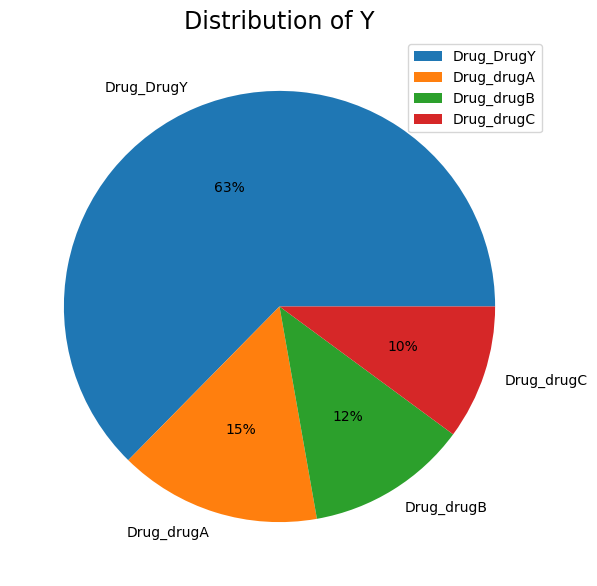

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = []
for col in y.columns:
    labels.append(col)
    
y_counts = []
for i_column in range(len(y.columns)):
    y_counts.append(len(y[y.iloc[:,i_column] == 1]))

plt.get_cmap('hsv')
plt.figure(figsize = (14,7))
colors = sns.color_palette('tab10')[0:5]
plt.title('Distribution of Y', fontsize = 17)
# plt.pie(y_counts, labels = labels, colors = colors, autopct='%.0f%%', explode=[0,0,.3])
plt.pie(y_counts, labels = labels, colors = colors, autopct='%.0f%%')
plt.legend()
plt.show()

In [6]:
y_counts

[62, 15, 12, 10]

# Partitioning the Data
- https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.3, stratify=y)

len_input = len(x_train.columns)
len_output = len(y_train.columns)

print("Len Input: {}".format(len_input))
print("Len Output: {}".format(len_output))

Len Input: 9
Len Output: 4


In [8]:
# check stratified samples

y_test_counts = []
for column_ in range(len(y_test.columns)):
    y_test_counts.append(len(y_test[y_test.iloc[:,column_] == 1]))
    print("{}: {}".format(labels[column_], y_test_counts[column_]))

y_test_counts

Drug_DrugY: 19
Drug_drugA: 4
Drug_drugB: 4
Drug_drugC: 3


[19, 4, 4, 3]

# Objective Function

- No Kfold Cross Validation

In [49]:
def f(params):
    x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.3, stratify=y)

    len_input = len(x_train.columns)
    len_output = len(y_train.columns)

    class CustomDataset(Dataset):
        def __init__(self, x, y):
            self.x = x
            self.y = y

            self.n_samples = len(x)

        def __getitem__(self, index):
            return self.x[index], self.y[index]

        def __len__(self):
            return self.n_samples
    
    def one_hot_encoding(nd_array):
        one_hot_encoding_predictions = nd_array

        for i in range(len(nd_array)):
            max_pred = max(nd_array[i])

            for j in range(len(nd_array[i])):
                one_hot_encoding_predictions[i][j] = 1 if nd_array[i][j] == max_pred else 0

        return one_hot_encoding_predictions

    # model
    class MultiLayerPerceptron(nn.Module):
        def __init__(self, input_dim, hidden_layer_size, output_dim):
            super().__init__()

            self.input = nn.Linear(input_dim, hidden_layer_size)
            self.output = nn.Linear(hidden_layer_size, output_dim)

        def forward(self, x, activation_function):
            # relu
            if activation_function == 'relu':
                x = F.relu(self.input(x))
            elif activation_function == 'tanh':
                x = torch.tanh(self.input(x))
            elif activation_function == 'leaky_relu':
                x = F.leaky_relu(self.input(x))
            elif activation_function == 'sigmoid':
                x = F.sigmoid(self.input(x))
            else:
                x = F.elu(self.input(x))
            
            
            x = torch.sigmoid(self.output(x))
            y = F.softmax(x, dim=-1)

            return y
    
    model = MultiLayerPerceptron(len_input, params["hidden_layer_size"], len_output)
    
    def train_fn(loader, model, optimizer, loss_fn, device):
        loop = tqdm(loader)

        average_loss = 0
        count = 0

        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            predictions = model.forward(data, params["activation_function"])

            predictions = F.softmax(predictions, dim=-1)

            loss = loss_fn(predictions, targets)

            # Backward
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            # Update tqdm
            loop.set_postfix(loss=loss.item())

            average_loss += loss.item()
            count += 1

        average_loss = average_loss / count

        return average_loss
    
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    epochs = 120
    
    x_train = torch.tensor(x_train.values).float().to(device)
    y_train = torch.tensor(y_train.values).float().to(device)

    x_test = torch.tensor(x_test.values).float().to(device)
    y_test = torch.tensor(y_test.values).float().to(device)

    # training the using the training dataset
    training_ds = CustomDataset(x_train, y_train)

    train_loader = DataLoader(training_ds, batch_size=params["batch_size"], shuffle=False, drop_last=False)
    
    y_test = y_test.detach().cpu().numpy()

    losses = []
    accuracies = []
    for epoch in range(epochs):
        average_loss = train_fn(train_loader, model, optimizer, criterion, device)
        one_hot_encoding_predictions = one_hot_encoding(model.forward(x_test,params["activation_function"]).detach().cpu().numpy())
        
        acc_score = accuracy_score(y_test, one_hot_encoding_predictions)
        losses.append(average_loss)
        accuracies.append(acc_score)
        
        print("Average Loss: {}".format(average_loss))
        print("Acc Score: {}".format(acc_score))
    
    predictions = model.forward(x_test, params["activation_function"])
    one_hot_encoding_predictions = one_hot_encoding(predictions.detach().cpu( ).numpy())

    accuracy = accuracy_score(y_test, one_hot_encoding_predictions)
    print("Accuracy: {}".format(accuracy))
    # returns error -- TypeError: estimator should be an estimator implementing 'fit' method, MultiLayerPerceptron( (input): Linear(in_features=9, out_features=7, bias=True) (output): Linear(in_features=7, out_features=4, bias=True) ) was passed
    # inspired by: https://www.analyticsvidhya.com/blog/2021/05/bayesian-optimization-bayes_opt-or-hyperopt/#:~:text=accuracy%20is%200.772.-,hyperopt,-Another%20package%20is
    # cross_val_score docs: https://scikit-learn.org/stable/modules/cross_validation.html
    #best_score = cross_val_score(average_loss, x, y, scoring=acc_score, cv=5).mean()
    #return 1 - best_score

    return average_loss



# Running hyperopt 2
**RUN 1 w/ Epoch 100**

best_params2 = {'activation_function': 2,'batch_size': 18.0, 'hidden_layer_size': 6.0, learning_rate': 0.00041812205042106234}

Changed bounds of batch_size from (10, 30) to (5, 20)

**RUN 2 w/ Epoch 120**


In [21]:
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

params_list = {
    'hidden_layer_size': scope.int(hp.quniform('hidden_layer_size', len_output+1, len_input-1, q=1)),
    'activation_function': hp.choice('activation_function', ['relu', 'tanh', 'leaky_relu', 'elu', 'Sigmoid']),
    'batch_size': scope.int(hp.quniform('batch_size', 5, 20, q=1)),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.001)
}

best_params2 = fmin(fn=f, space=params_list, max_evals=24, algo=tpe.suggest)

best_params2

  0%|                                    | 0/24 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.891]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.89] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.891]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.89] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.891]

  0%|          | 0/7 [00:00<


  0%|          | 0/7 [00:00<?, ?it/s, loss=0.888]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.887]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.888]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.887]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.887]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.887]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.18] 

  0%|    


  0%|          | 0/7 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.987]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.986]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [0


  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.872]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.874]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.983]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.872]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.874]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.983]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.871]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.874]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.983]

  0%|     


  0%|          | 0/7 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.872]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.872]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.871]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.871]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/7 [0

Accuracy: 0.4634146341463415                                                    
  4%|▍         | 1/24 [00:04<01:52,  4.88s/trial, best loss: 1.0111421516963415]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.593]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.788]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.789]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.687]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/14 [00:00<?, ?it/s, los


  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.986]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.785]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.785]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.682]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.591]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.985]

  0%|          | 0/14 [00:00<


  0%|          | 0/14 [00:00<?, ?it/s, loss=0.675]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.588]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.98]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.779]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.779]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.674]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, los


  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.584]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.976]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.775]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.775]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.669]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.584]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00


  0%|          | 0/14 [00:00<?, ?it/s, loss=0.772]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.666]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.582]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.974]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.773]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.772]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.666]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, 


  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.582]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.972]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.665]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.581]

  0%|          | 0/14 [00:0


  0%|          | 0/14 [00:00<?, ?it/s, loss=0.972]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.581]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.972]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/14 [00:0


  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.581]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?,


  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.581]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?,

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.58]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.


  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.58]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.58]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.663]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.


  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.663]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.58]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/14 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/14 [00:00<?, ?it/s, loss=0.77] 

  0%|          | 0/14 [00:00<?, ?

Accuracy: 0.4634146341463415                                                    
  8%|▊         | 2/24 [00:13<02:35,  7.05s/trial, best loss: 0.9893456867762974]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.695]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.694]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.695]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, lo


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.694]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.694]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, l


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.694]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.694]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/12 [00:00<?, ?it/s, los


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, los


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.689]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.86]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.689]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.86]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.688]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.856]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.69]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.687]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.856]

  0%|          | 0/12 [00:00<?, ?it/s, loss


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.686]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.852]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.689]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.857]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.686]

  0%|          | 0/12 [00:00<?, ?it/s, los


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.855]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.685]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.849]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.01]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.687]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.855]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/12 [00:00<?


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.847]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.01]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.687]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.853]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.684]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.846]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.01]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.686]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.853]

  0%|          | 0/12 [00:00

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.684]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.845]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1]   

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.686]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.852]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.36]

100%|##########| 12/12 [00:00<00:00, 233.44it/s, loss=1.36]


Accuracy: 0.4634146341463415                                                    
 12%|█▎        | 3/24 [00:21<02:37,  7.51s/trial, best loss: 0.9893456867762974]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.951]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.803]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.95]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.803]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.95]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.803]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s,


  0%|          | 0/5 [00:00<?, ?it/s, loss=0.801]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.801]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.8]  

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.8]  

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [0


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.935]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.934]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.934]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/


  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.793]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it

Accuracy: 0.4634146341463415                                                    
 17%|█▋        | 4/24 [00:25<01:59,  5.95s/trial, best loss: 0.9893456867762974]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.994]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.894]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.994]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.894]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.994]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7


  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.893]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.893]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.893]

  0%|    


  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.892]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.892]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.892]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7


  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.892]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.892]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.891]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.891]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [0


  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.89]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.89]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.89]

  0%|         


  0%|          | 0/7 [00:00<?, ?it/s, loss=0.889]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.987]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.889]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.987]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.792]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.889]

  0%|          | 0/7 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.987]

  0%|          | 0/

Accuracy: 0.4634146341463415                                                    
 21%|██        | 5/24 [00:29<01:43,  5.46s/trial, best loss: 0.9893456867762974]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/8 [


  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|      

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/8 [


  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.919]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.919]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.919]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|      


  0%|          | 0/8 [00:00<?, ?it/s, loss=0.914]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.915]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.915]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.915]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.915]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03] 

  0%|    


  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.03]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|      

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.905]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.908]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.91]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.905]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.908]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.905]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02] 

  0%|      


  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.908]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.902]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.907]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.901]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/8 [00:00<?, ?it/s, loss=1.02]

  0%|      

Accuracy: 0.4634146341463415                                                    
 25%|██▌       | 6/24 [00:34<01:37,  5.41s/trial, best loss: 0.9893456867762974]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.63]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.756]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.63]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.629]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.756]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.63]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.831]

  0%|         


  0%|          | 0/9 [00:00<?, ?it/s, loss=0.628]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.754]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.629]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.83]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.628]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.754]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.629]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|   


  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.751]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.629]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.826]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.623]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.751]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.629]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.826]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.623]

  0%|  


  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.747]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.627]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.617]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.746]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.627]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.616]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|    


  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.743]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.626]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.816]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.611]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.743]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.25] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.626]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.816]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.611]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|  


  0%|          | 0/9 [00:00<?, ?it/s, loss=0.741]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.626]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.608]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.741]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.626]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.607]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|  


  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.625]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.606]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.74]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.625]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.606]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.74]

  0%|      


  0%|          | 0/9 [00:00<?, ?it/s, loss=0.625]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.605]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.739]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.625]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.605]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.739]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.625]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.604]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.739]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.625]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.604]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.739]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.24] 

  0%|   

Accuracy: 0.4634146341463415                                                    
 29%|██▉       | 7/24 [00:40<01:33,  5.51s/trial, best loss: 0.9893456867762974]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<


  0%|          | 0/5 [00:00<?, ?it/s, loss=0.948]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.877]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.946]

  0%|          


  0%|          | 0/5 [00:00<?, ?it/s, loss=0.944]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.944]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.944]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.944]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.944]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.944]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.944]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.942]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.942]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.942]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.942]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.942]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.942]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.94] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.94]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.94] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.94]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.939]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.94]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.876]

  0%|          | 0/5 [00:00<?, ?it/s

Accuracy: 0.4634146341463415                                                    
 33%|███▎      | 8/24 [00:44<01:18,  4.93s/trial, best loss: 0.9893456867762974]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.553]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.832]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.83] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.553]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.832]

  0%|          | 0/19 [00:00<?, ?


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.826]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.823]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.827]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.546]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.827]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/19 [00:00<?, 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.819]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.817]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.826]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.539]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.917]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.819]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.538]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.827]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.535]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.816]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.914]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.815]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.534]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, 


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.532]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.827]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?,

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.532]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.827]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.532]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/19 [00:00<?, 


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?,


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?,


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?,


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?,


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?,


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.531]

  0%|          | 0/19 [00:00<?,

Accuracy: 0.4634146341463415                                                    
 38%|███▊      | 9/24 [00:55<01:42,  6.86s/trial, best loss: 0.9893456867762974]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.832]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.554]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.834]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/19 [00:00<?


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.826]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.822]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.552]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.827]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.825]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.825]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.809]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.549]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.808]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.817]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.818]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.818]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?,


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.816]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.801]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.814]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.801]

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.798]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.35]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.799]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.798]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.797]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.797]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.813]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.797]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.797]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.797]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

 89%|########9 | 17/19 [00:00<00:00, 165.06it/s, loss=0.796]

 89%|########9 | 17/19 [00:00<00:00, 165.06it/s, loss=0.812]

 89%|########9 | 17/19 [00:00<00:00, 165.06it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08]


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

100%|##########| 19/19 [00:00<00:00, 162.80it/s, loss=1.33]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<


  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

 95%|#########4| 18/19 [00:00<00:00, 178.14it/s, loss=0.812]

 95%|#########4| 18/19 [00:00<00:00, 178.14it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|    


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.547]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

100%|##########| 19/19 [00:00<00:00, 187.83it/s, loss=1.33]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0


  0%|          | 0/19 [00:00<?, ?it/s, loss=0.828]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.33] 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.812]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.34]

  0%|          | 0/19 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/19 [00:00<?, ?it/s, loss=0.796]

  0%|          | 0/19 [00:00<

Accuracy: 0.4634146341463415                                                    
 42%|███▊     | 10/24 [01:07<01:59,  8.54s/trial, best loss: 0.9893456867762974]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]    

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]   

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]    

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]   

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]    

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]   

  0%|          | 0/6 [00:00


  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.998]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.92]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.997]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.92]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.997]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.92]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/6 


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.987]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.987]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.98] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.907]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.98] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.98] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<


  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.904]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.978]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.904]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.978]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.904]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.978]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [0


  0%|          | 0/6 [00:00<?, ?it/s, loss=0.977]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.977]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.977]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0


  0%|          | 0/6 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.976]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.976]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.989]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.976]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 

Accuracy: 0.4634146341463415                                                    
 46%|████▏    | 11/24 [01:12<01:35,  7.36s/trial, best loss: 0.9893456867762974]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.928]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.929]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.929]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.929]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.696]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s,


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.919]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.692]

 94%|#########3| 15/16 [00:00<00:00, 146.81it/s, loss=0.692]

 94%|#########3| 15/16 [00:00<00:00, 146.81it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.917]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.684]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.919]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.916]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.915]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.916]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.916]

  0%|          | 0/16 [00


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.896]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.907]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.931]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.671]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.4]  

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.914]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.889]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.891]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.902]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.934]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.902]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.667]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.4]  

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.901]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.901]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.889]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.891]

  0%|          | 0/16 [00


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.4]  

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.887]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.888]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.9]  

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.936]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.9]  

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.665]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.4]  

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s,


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.886]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.937]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.937]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.886]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.937]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.937]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s,


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.937]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.937]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/16 [00


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.938]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.664]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.938]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.663]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.938]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.663]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.41] 

100%|##########| 16/16 [00:00<00:00, 157.80it/s, loss=1.41]

  0%|          |

Accuracy: 0.4634146341463415                                                    
 50%|████▌    | 12/24 [01:23<01:41,  8.49s/trial, best loss: 0.9893456867762974]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.948]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.977]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.948]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.976]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.948]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.976]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02]

  0%|          | 0/5 [00:00<?, ?it/


  0%|          | 0/5 [00:00<?, ?it/s, loss=0.942]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.01]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.941]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.01]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.941]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.01]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.941]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/5 [0


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.963]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.933]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.963]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.932]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.962]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.932]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.962]

  0%|          | 0/5 [00:00<?, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.998]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.928]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.959]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.998]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.928]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.959]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.997]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.928]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.958]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.997]

  0%|          | 0/5 [00:00<?, 


  0%|          | 0/5 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.957]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.957]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.957]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.956]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.995]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.956]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.995]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.956]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.995]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.926]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/

Accuracy: 0.4634146341463415                                                    
 54%|████▉    | 13/24 [01:27<01:18,  7.18s/trial, best loss: 0.9893456867762974]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, los


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, lo


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.83]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.863]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.83]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.863]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.83]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.863]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, l

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.861]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/12 [00:00<?,


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.86] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.861]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.689]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.827]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.86] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.861]

  0%|          | 0/12 [00:00<?,

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.858]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.688]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.826]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.858]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.825]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.857]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.857]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.686]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.824]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.857]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.685]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.823]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.863]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.855]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.855]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.685]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.823]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.853]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.684]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.863]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.853]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.853]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.684]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, lo


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.852]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.682]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.851]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.851]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.682]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, 


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.849]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.681]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.819]

100%|##########| 12/12 [00:00<00:00, 199.79it/s, loss=0.819]


Accuracy: 0.4634146341463415                                                    
 58%|█████▎   | 14/24 [01:36<01:15,  7.54s/trial, best loss: 0.9893456867762974]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.9] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/5 [00:00<?, ?it/s, lo


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.897]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.969]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.897]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.969]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.897]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.969]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.897]

  0%|          | 0/


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.967]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.893]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.967]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.893]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.967]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.893]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.964]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.888]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.964]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.888]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.964]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.887]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.964]

  0%|          | 0/5 [00:00<?, 


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.881]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.961]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.881]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.961]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.881]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.961]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.881]

  0%|          | 0/

Accuracy: 0.4634146341463415                                                    
 62%|█████▋   | 15/24 [01:39<00:57,  6.44s/trial, best loss: 0.9893456867762974]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.763]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.763]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.763]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/5 [00:00<?, ?it/s, 


  0%|          | 0/5 [00:00<?, ?it/s, loss=0.762]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.762]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.761]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.761]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/5 [00


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.759]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.758]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.758]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.17]

  0%|          | 0/5 [00:00<?, ?it/s,


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.755]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.755]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.755]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.755]

  0%|          | 0/5 [00:


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.752]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.752]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.752]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s,


  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.751]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.751]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/5 [00:00<?, ?it/s, loss=0.751]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.02] 

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/5 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/5 [00:0

Accuracy: 0.4634146341463415                                                    
 67%|██████   | 16/24 [01:43<00:45,  5.63s/trial, best loss: 0.9893456867762974]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.979]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.98] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.979]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.98] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.979]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.979]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/6 [00


  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.976]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.974]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.975]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.974]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.975]

  0%|          | 0/6 


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.964]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.97]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.963]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/6 [00


  0%|          | 0/6 [00:00<?, ?it/s, loss=0.957]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.967]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.956]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.966]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.956]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 


  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.953]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.953]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.953]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.952]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.952]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.952]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|     


  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.952]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.952]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.03] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.965]

  0%|          | 0/6 

Accuracy: 0.4634146341463415                                                    
 71%|██████▍  | 17/24 [01:47<00:36,  5.22s/trial, best loss: 0.9893456867762974]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]    

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]    

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1]    

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/6 [00:00<?,


  0%|          | 0/6 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.997]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.999]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.997]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.92] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.999]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.997]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.92] 

  0%|          | 0


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.917]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.993]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.917]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.917]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.996]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 


  0%|          | 0/6 [00:00<?, ?it/s, loss=0.994]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.914]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.994]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.994]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.905]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.988]

  0%|          | 0


  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.985]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.901]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.985]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.901]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.985]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.992]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.9]  

  0%|          | 0


  0%|          | 0/6 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.983]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.983]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.991]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.898]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0


  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.908]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.896]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.908]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.896]

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/6 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.982]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.908]

  0%|          | 0/6 [00:00<?, ?it/s, loss=0.99] 

  0%|          | 0

Accuracy: 0.4634146341463415                                                    
 75%|██████▊  | 18/24 [01:52<00:29,  4.88s/trial, best loss: 0.9893456867762974]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.617]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.772]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.617]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.0


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.617]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.772]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.617]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.772]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.617]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?,


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.616]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.771]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.616]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.


  0%|          | 0/11 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.616]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.77]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.615]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.768]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.615]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.768]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.614]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.766]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.462]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.614]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.0


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.462]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.613]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.764]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.462]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.612]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.762]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.463]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.612]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.762]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.463]

  0%|          | 0/11 [00:00<?,


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.611]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.76]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.464]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.611]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05] 

  0%|          | 0/11 [00:00<?, ?it/


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.465]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.61]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.758]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.04] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.465]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.05]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.21

Accuracy: 0.4634146341463415                                                    
 79%|███████▏ | 19/24 [01:59<00:28,  5.61s/trial, best loss: 0.9779936698350039]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.837]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.837]

  0%|   


  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.837]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.837]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.836]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.885]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.836]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|   


  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.836]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.836]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|  

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.835]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.835]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|   


  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.835]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.835]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.884]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|  

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.834]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.834]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|   


  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.882]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.882]

  0%|  

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.882]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.883]

  0%|          | 0/9 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/9 [00:00<?, ?it/s, loss=0.882]

  0%|   

Accuracy: 0.07317073170731707                                                   
 83%|███████▌ | 20/24 [02:05<00:22,  5.68s/trial, best loss: 0.9779936698350039]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.519]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.869]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.868]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.518]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/12 [00:00<?, ?it/s, lo


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.863]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.517]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.867]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.866]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.517]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21] 

  0%|          | 0/12 [00:00<?, ?it/s, l


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.1]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.515]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.865]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.861]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.1]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.864]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.858]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.854]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.513]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.862]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.858]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.2]  

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.861]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.855]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.86]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.511]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.861]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.855]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?,


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.86]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.853]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.846]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.509]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.86]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.844]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.509]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.852]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.844]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.509]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.19]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.842]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.508]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.851]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.842]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.508]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, lo


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.842]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.508]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.842]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.508]

  0%|          | 0/12 [00:00<?, ?it/s, loss


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.841]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.508]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0


  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.841]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.508]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/12 [00:00<?, ?


  0%|          | 0/12 [00:00<?, ?it/s, loss=1.21]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.859]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18] 

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=0.85]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.18]

  0%|          | 0/12 [00:00<?, ?it/s, loss=1.08]

100%|##########| 12/12 [00:00<00:00, 230.14it/s, loss=1.08]


Accuracy: 0.4634146341463415                                                    
 88%|███████▉ | 21/24 [02:12<00:18,  6.23s/trial, best loss: 0.9779936698350039]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.769]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.925]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.769]

  0%|          | 0/11 [00:00<?, ?it/s, loss


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.459]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.767]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.92] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.764]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.916]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.919]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.92] 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.456]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.763]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.915]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.23] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.92] 

  0%|          | 0/11 [00:00

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.452]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.758]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.917]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.451]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.758]

  0%|          | 0/11 [00:00<?, ?it/s, loss


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.914]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.448]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.753]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.909]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.914]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.75]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.9] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.445]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.75]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.899]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.906]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/11 [00:00<?, 


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.444]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.749]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.897]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.904]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.444]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.749]

  0%|          | 0/11 [00:00<?, ?it/s, los


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.904]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.443]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.748]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.896]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.904]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, los


  0%|          | 0/11 [00:00<?, ?it/s, loss=0.443]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.747]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.895]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.443]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.747]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.895]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/11 [00:00


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.443]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.747]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.895]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.443]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.747]

  0%|          | 0/11 [00:00<?, ?it/s, los


  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.443]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.747]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.894]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.22] 

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.903]

  0%|          | 0/11 [00:00<?, ?it/s, loss=0.911]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.07]

  0%|          | 0/11 [00:00<?, ?it/s, loss=1.06]

  0%|          | 0/11 [00:00<?, ?it/s, los

Accuracy: 0.4634146341463415                                                    
 92%|████████▎| 22/24 [02:19<00:13,  6.53s/trial, best loss: 0.9779936698350039]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.694]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.39] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.16]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.462]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.461]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

 94%|#########3| 15/16 [00:00<00:00, 145.96it/s, loss=1.15]

 94%|#########3| 15/16 [00:00<00:00, 145.96it/s, loss=0.459]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.689]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|      


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.693]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.688]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.922]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.924]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.458]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, 


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.456]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.685]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.921]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.454]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.682]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.92] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.454]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.679]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.918]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.15]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.452]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.45]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.676]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.917]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, 


  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.673]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.916]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.448]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.447]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.671]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.915]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.669]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.914]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.446]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.668]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.445]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.668]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/16 [00:00<?,

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.444]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.667]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.444]

  0%|          | 0/16 [00:00<?, 


  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.666]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.913]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.14]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.444]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?,

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.923]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.443]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.12]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.691]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.666]

  0%|          | 0/16 [00:00<?, ?it/s, loss=0.912]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.37] 

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?it/s, loss=1.13]

  0%|          | 0/16 [00:00<?, ?i

Accuracy: 0.4634146341463415                                                    
 96%|████████▋| 23/24 [02:28<00:07,  7.21s/trial, best loss: 0.9779936698350039]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.25]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.832]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.972]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.694]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.97] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.25]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.832]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.39]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.833]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.971]

  0%|          | 0/10 [00:00<?, ?it/s, loss


  0%|          | 0/10 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.967]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.831]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.11] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.832]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.969]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.692]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.967]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.83]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.11]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/10 [00:00<?, ?it/s, los


  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.83]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.966]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.963]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.24]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.829]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.1]  

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.1] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.83]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.966]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.69] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.963]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.38] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, los


  0%|          | 0/10 [00:00<?, ?it/s, loss=0.957]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.684]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.954]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.824]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.825]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.956]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.684]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.954]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.23]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.824]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/10 [00:00<?, ?it/s, 


  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.823]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.952]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.682]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.95] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.822]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.823]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.952]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.682]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.95] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.36]

  0%|          | 0/10 [00:00<?


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.822]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.681]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.948]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.822]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.949]

  0%|          | 0/10 [00:00<?, ?it/s, lo


  0%|          | 0/10 [00:00<?, ?it/s, loss=0.948]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.68] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.68] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.36] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08] 

  0%|          | 0/10 [00:00<?, ?it/s, 


  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.68] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.947]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.68] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/10 [00:00<?,


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.68] 

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.35] 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.22]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.82]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.08]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.37]

  0%|          | 0/10 [00:00<?, ?it/s, loss=1.09]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.821]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0.946]

  0%|          | 0/10 [00:00<?, ?it/s, loss=0

Accuracy: 0.4634146341463415                                                    
100%|█████████| 24/24 [02:34<00:00,  6.43s/trial, best loss: 0.9779936698350039]


{'activation_function': 4,
 'batch_size': 9.0,
 'hidden_layer_size': 7.0,
 'learning_rate': 0.0002672683008577046}

# Running hyperopt 1
**RUN 1 w/ Epoch 100**

Accuracy: 0.4634146341463415                                                    

best_params = {'activation_function': 2,
 'batch_size': 7.0,
 'hidden_layer_size': 7.0,
 'learning_rate': 0.00047244599466539757}

**RUN 2 w/ Epoch 120:**

Accuracy: 0.4634146341463415                                                    

best_params = {'activation_function': 2,
 'batch_size': 13.0,
 'hidden_layer_size': 5.0,
 'learning_rate': 0.00025260098947031917}


In [ ]:
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

params_list = {
    'hidden_layer_size': scope.int(hp.quniform('hidden_layer_size', len_output+1, len_input-1, q=1)),
    'activation_function': hp.choice('activation_function', ['relu', 'tanh', 'leaky_relu', 'elu', 'Sigmoid']),
    'batch_size': scope.int(hp.quniform('batch_size', 10, 30, q=1)),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.001)
}

best_params = fmin(fn=f, space=params_list, max_evals=24, algo=tpe.suggest)

best_params

# Running hyperopt 3
Accuracy: 0.5853658536585366                                                    

{'activation_function': 0,
 'batch_size': 10.0,
 'hidden_layer_size': 6.0,
 'learning_rate': 0.0056595946190019395}
 
changed learning_rate from (0.0001, 0.001)to (0.0001, 0.01)

In [ ]:
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

params_list = {
    'hidden_layer_size': scope.int(hp.quniform('hidden_layer_size', len_output+1, len_input-1, q=1)),
    'activation_function': hp.choice('activation_function', ['relu', 'tanh', 'leaky_relu', 'elu', 'Sigmoid']),
    'batch_size': scope.int(hp.quniform('batch_size', 5, 20, q=1)),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01)
}

best_params3 = fmin(fn=f, space=params_list, max_evals=24, algo=tpe.suggest)

best_params3

# Running hyperopt 4
Accuracy: 0.4634146341463415                                                    

{'activation_function': 0,
 'batch_size': 11.0,
 'hidden_layer_size': 7.0,
 'learning_rate': 0.0006520056006323331}

In [ ]:
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

params_list = {
    'hidden_layer_size': scope.int(hp.quniform('hidden_layer_size', len_output+1, len_input-1, q=1)),
    'activation_function': hp.choice('activation_function', ['relu', 'tanh', 'leaky_relu', 'elu', 'Sigmoid']),
    'batch_size': scope.int(hp.quniform('batch_size', 9, 15, q=1)),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.0009)
}

best_params4 = fmin(fn=f, space=params_list, max_evals=24, algo=tpe.suggest)

best_params4

# Running hyperopt 5
RUN 1: Epoch = 100
Accuracy: 0.4634146341463415                                                    

{'activation_function': 4,
 'batch_size': 13.0,
 'hidden_layer_size': 7.0,
 'learning_rate': 0.0004361580679759118}

In [ ]:
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

params_list = {
    'hidden_layer_size': scope.int(hp.quniform('hidden_layer_size', len_output+1, len_input-1, q=1)),
    'activation_function': hp.choice('activation_function', ['relu', 'tanh', 'leaky_relu', 'elu', 'Sigmoid']),
    'batch_size': scope.int(hp.quniform('batch_size', 9, 15, q=1)),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.0009)
}

best_params5 = fmin(fn=f, space=params_list, max_evals=30, algo=tpe.suggest)

best_params5

# Final Model

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.3, stratify=y)

len_input = len(x_train.columns)
len_output = len(y_train.columns)

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

        self.n_samples = len(x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

def one_hot_encoding(nd_array):
    one_hot_encoding_predictions = nd_array

    for i in range(len(nd_array)):
        max_pred = max(nd_array[i])

        for j in range(len(nd_array[i])):
            one_hot_encoding_predictions[i][j] = 1 if nd_array[i][j] == max_pred else 0

    return one_hot_encoding_predictions

# model
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input = nn.Linear(input_dim, 7)
        self.output = nn.Linear(7, output_dim)

    def forward(self, x):
        # relu
        x = F.relu(self.input(x))
        x = torch.sigmoid(self.output(x))
        y = F.softmax(x, dim=-1)

        return y

model = MultiLayerPerceptron(len_input, len_output)

def train_fn(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader)

    average_loss = 0
    count = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward
        predictions = model.forward(data)

        predictions = F.softmax(predictions, dim=-1)

        loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Update tqdm
        loop.set_postfix(loss=loss.item())

        average_loss += loss.item()
        count += 1

    average_loss = average_loss / count

    return average_loss

optimizer = optim.Adam(model.parameters(), lr=0.0056595946190019395)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

epochs = 120

x_train = torch.tensor(x_train.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)

x_test = torch.tensor(x_test.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)

training_ds = CustomDataset(x_train, y_train)

train_loader = DataLoader(training_ds, batch_size=10, shuffle=False, drop_last=False)

y_test = y_test.detach().cpu().numpy()

losses = []
accuracies = []
for epoch in range(epochs):
    average_loss = train_fn(train_loader, model, optimizer, criterion, device)
    one_hot_encoding_predictions = one_hot_encoding(model.forward(x_test).detach().cpu().numpy())

    acc_score = accuracy_score(y_test, one_hot_encoding_predictions)
    losses.append(average_loss)
    accuracies.append(acc_score)

    print("Average Loss: {}".format(average_loss))
    print("Acc Score: {}".format(acc_score))

predictions = model.forward(x_test)
one_hot_encoding_predictions = one_hot_encoding(predictions.detach().cpu( ).numpy())

accuracy = accuracy_score(y_test, one_hot_encoding_predictions)
print("Accuracy: {}".format(accuracy))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 234.76it/s, loss=1.39]


Average Loss: 1.0538536727428436
Acc Score: 0.21951219512195122


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 304.74it/s, loss=1.38]


Average Loss: 1.0513709604740142
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 280.27it/s, loss=1.37]


Average Loss: 1.0474380254745483
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 310.67it/s, loss=1.37]


Average Loss: 1.0423202157020568
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 256.07it/s, loss=1.36]


Average Loss: 1.0374555468559266
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 269.82it/s, loss=1.36]


Average Loss: 1.0341693818569184
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 307.41it/s, loss=1.35]


Average Loss: 1.032538741827011
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 312.96it/s, loss=1.35]


Average Loss: 1.0318278074264526
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 320.80it/s, loss=1.35]


Average Loss: 1.031506645679474
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 329.49it/s, loss=1.35]


Average Loss: 1.0313444435596466
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 332.48it/s, loss=1.35]


Average Loss: 1.03125159740448
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 296.08it/s, loss=1.35]


Average Loss: 1.0311923503875733
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 308.88it/s, loss=1.35]


Average Loss: 1.0311512887477874
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 347.39it/s, loss=1.35]


Average Loss: 1.0311210036277771
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 375.47it/s, loss=1.35]


Average Loss: 1.0310977280139924
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 354.46it/s, loss=1.35]


Average Loss: 1.0310792207717896
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 358.31it/s, loss=1.35]


Average Loss: 1.0310642421245575
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 374.53it/s, loss=1.35]


Average Loss: 1.0310518443584442
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 374.42it/s, loss=1.35]


Average Loss: 1.0310415089130402
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 421.28it/s, loss=1.35]


Average Loss: 1.0310327231884002
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 401.98it/s, loss=1.35]


Average Loss: 1.0310252368450166
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 396.87it/s, loss=1.35]


Average Loss: 1.0310187637805939
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 416.39it/s, loss=1.35]


Average Loss: 1.0310130953788756
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 421.80it/s, loss=1.35]


Average Loss: 1.031008118391037
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 384.57it/s, loss=1.35]


Average Loss: 1.0310037791728974
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 434.99it/s, loss=1.35]


Average Loss: 1.030999916791916
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 402.69it/s, loss=1.35]


Average Loss: 1.0309964776039124
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 395.32it/s, loss=1.35]


Average Loss: 1.0309934139251709
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 350.72it/s, loss=1.35]


Average Loss: 1.0309906125068664
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 349.88it/s, loss=1.35]


Average Loss: 1.0309881210327148
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 433.90it/s, loss=1.35]


Average Loss: 1.030985850095749
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 464.27it/s, loss=1.35]


Average Loss: 1.0309837639331818
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 400.19it/s, loss=1.35]


Average Loss: 1.0309818506240844
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 445.43it/s, loss=1.35]


Average Loss: 1.0309800922870636
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 446.51it/s, loss=1.35]


Average Loss: 1.030978536605835
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 426.53it/s, loss=1.35]


Average Loss: 1.0309770703315735
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 423.66it/s, loss=1.35]


Average Loss: 1.0309757590293884
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 441.89it/s, loss=1.35]


Average Loss: 1.0309744775295258
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 447.38it/s, loss=1.35]


Average Loss: 1.0309732973575592
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 428.69it/s, loss=1.35]


Average Loss: 1.0309722185134889
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 443.52it/s, loss=1.35]


Average Loss: 1.0309711813926696
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 475.73it/s, loss=1.35]


Average Loss: 1.0309702277183532
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 471.13it/s, loss=1.35]


Average Loss: 1.030969351530075
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 496.46it/s, loss=1.35]


Average Loss: 1.0309684932231904
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 474.86it/s, loss=1.35]


Average Loss: 1.0309676945209503
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 488.18it/s, loss=1.35]


Average Loss: 1.0309669733047486
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 453.97it/s, loss=1.35]


Average Loss: 1.0309662461280822
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 453.25it/s, loss=1.35]


Average Loss: 1.0309655904769897
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 459.82it/s, loss=1.35]


Average Loss: 1.0309649586677552
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 447.91it/s, loss=1.35]


Average Loss: 1.0309643626213074
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 471.59it/s, loss=1.35]


Average Loss: 1.0309637188911438
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 465.29it/s, loss=1.35]


Average Loss: 1.0309631943702697
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 453.18it/s, loss=1.35]


Average Loss: 1.0309626758098602
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 448.25it/s, loss=1.35]


Average Loss: 1.0309621751308442
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 447.26it/s, loss=1.35]


Average Loss: 1.0309617042541503
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 454.69it/s, loss=1.35]


Average Loss: 1.0309612274169921
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 431.01it/s, loss=1.35]


Average Loss: 1.030960774421692
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 457.64it/s, loss=1.35]


Average Loss: 1.0309602856636046
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 459.33it/s, loss=1.35]


Average Loss: 1.0309598684310912
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 440.66it/s, loss=1.35]


Average Loss: 1.0309594750404358
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 463.22it/s, loss=1.35]


Average Loss: 1.0309590339660644
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 423.86it/s, loss=1.35]


Average Loss: 1.030958616733551
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 424.20it/s, loss=1.35]


Average Loss: 1.03095822930336
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 439.43it/s, loss=1.35]


Average Loss: 1.0309578001499176
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 435.56it/s, loss=1.35]


Average Loss: 1.030957442522049
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 432.77it/s, loss=1.35]


Average Loss: 1.0309570252895355
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 408.60it/s, loss=1.35]


Average Loss: 1.03095663189888
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 403.78it/s, loss=1.35]


Average Loss: 1.0309562146663667
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 407.68it/s, loss=1.35]


Average Loss: 1.0309558510780334
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 435.58it/s, loss=1.35]

Average Loss: 1.0309554755687713


Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 433.80it/s, loss=1.35]


Average Loss: 1.030955058336258
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 430.26it/s, loss=1.35]


Average Loss: 1.0309546530246734
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 431.91it/s, loss=1.35]


Average Loss: 1.0309542059898376
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 435.41it/s, loss=1.35]


Average Loss: 1.0309537470340728
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 456.22it/s, loss=1.35]


Average Loss: 1.030953299999237
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 429.78it/s, loss=1.35]


Average Loss: 1.0309528768062592
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 445.17it/s, loss=1.35]


Average Loss: 1.0309523940086365
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 459.18it/s, loss=1.35]


Average Loss: 1.0309518873691559
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 415.77it/s, loss=1.35]


Average Loss: 1.030951350927353
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 457.31it/s, loss=1.35]


Average Loss: 1.0309507548809052
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 438.36it/s, loss=1.35]


Average Loss: 1.0309501767158509
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 447.60it/s, loss=1.35]


Average Loss: 1.0309495747089386
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 446.51it/s, loss=1.35]


Average Loss: 1.0309488594532012
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 428.55it/s, loss=1.35]


Average Loss: 1.0309480905532837
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 402.51it/s, loss=1.35]


Average Loss: 1.0309472620487212
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 416.72it/s, loss=1.35]


Average Loss: 1.030946320295334
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 451.18it/s, loss=1.35]


Average Loss: 1.0309453010559082
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 149.37it/s, loss=1.35]


Average Loss: 1.030944174528122
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 393.27it/s, loss=1.35]


Average Loss: 1.0309428811073302
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 433.20it/s, loss=1.35]


Average Loss: 1.0309414505958556
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 429.48it/s, loss=1.35]


Average Loss: 1.0309397459030152
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 410.22it/s, loss=1.35]


Average Loss: 1.0309377789497376
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 371.31it/s, loss=1.35]


Average Loss: 1.03093541264534
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 453.61it/s, loss=1.35]


Average Loss: 1.030932641029358
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 456.92it/s, loss=1.35]

Average Loss: 1.030929148197174


Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 464.56it/s, loss=1.35]


Average Loss: 1.0309248208999633
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 447.73it/s, loss=1.35]


Average Loss: 1.0309192657470703
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 478.26it/s, loss=1.35]


Average Loss: 1.0309118926525116
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 470.17it/s, loss=1.35]


Average Loss: 1.0309017479419709
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 468.60it/s, loss=1.35]


Average Loss: 1.0308877766132354
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 437.67it/s, loss=1.35]


Average Loss: 1.0308740139007568
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 455.96it/s, loss=1.35]


Average Loss: 1.03085498213768
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 458.02it/s, loss=1.35]


Average Loss: 1.0308274269104003
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 461.91it/s, loss=1.35]


Average Loss: 1.0307855904102325
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 456.50it/s, loss=1.35]


Average Loss: 1.030722165107727
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 487.31it/s, loss=1.35]


Average Loss: 1.030624669790268
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 440.78it/s, loss=1.35]


Average Loss: 1.030470085144043
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 473.98it/s, loss=1.35]


Average Loss: 1.030250906944275
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 467.31it/s, loss=1.35]


Average Loss: 1.0300195276737214
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 456.23it/s, loss=1.35]


Average Loss: 1.029853767156601
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 470.77it/s, loss=1.35]


Average Loss: 1.0296549201011658
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 473.10it/s, loss=1.35]


Average Loss: 1.0295116186141968
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 416.03it/s, loss=1.35]


Average Loss: 1.0293988466262818
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 467.55it/s, loss=1.35]


Average Loss: 1.029297012090683
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 439.35it/s, loss=1.35]


Average Loss: 1.029207217693329
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 440.45it/s, loss=1.35]


Average Loss: 1.0291237115859986
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 469.35it/s, loss=1.35]


Average Loss: 1.0290416955947876
Acc Score: 0.4634146341463415


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 458.07it/s, loss=1.35]


Average Loss: 1.0289583861827851
Acc Score: 0.4878048780487805


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 429.00it/s, loss=1.35]


Average Loss: 1.0288618564605714
Acc Score: 0.4878048780487805


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 444.66it/s, loss=1.35]


Average Loss: 1.0287535071372986
Acc Score: 0.4878048780487805
Accuracy: 0.4878048780487805


In [7]:
state = { 'state_dict': model.state_dict() }

torch.save(state, "drugs.pth")